In [38]:
import torch 
import torch.nn as nn
import torchmetrics
from torch.utils.data import Dataset
import pandas as pd

In [39]:
import torch.nn as nn 
import numpy as np

torch.manual_seed(42)

np.random.seed(42)

BATCH_SIZE = 32
LR = 0.001
CLASSES = 6

TRAIN_VAL_TEST_SPLIT = [0.7, 0.15, 0.15]

EPOCHS = 40
LOSS_FUNCTION =nn.CrossEntropyLoss(weight=torch.tensor([2.0, 1.0,3.0,4.0,1.0,2.0]))#pos_weight=torch.tensor([10.0])

AUGMENT = True
SAVE_BEST_MODEL = True
IS_MULTICLASS = True if CLASSES > 2 else False
NUM_OF_WORKERS = 0

In [40]:
[i for i in range(6)], [*"Pastry Z_Scratch K_Scratch Stains Dirtiness Bumps".split(" ")] # V28 V29 V30 V31 V32 V33

([0, 1, 2, 3, 4, 5],
 ['Pastry', 'Z_Scratch', 'K_Scratch', 'Stains', 'Dirtiness', 'Bumps'])

In [41]:

class SteelPlateDataset(Dataset):

    def __init__(self, dataset_path):
        super().__init__()
        self.path = dataset_path
        self.df = pd.read_csv(self.path)

        self.features = self.df.drop(["Class", *("Pastry Z_Scratch K_Scratch Stains Dirtiness Bumps".split(" "))] ,axis= 1).values.tolist() # V28 V29 V30 V31 V32 V33
        self.labels =  self.df[[*"Pastry Z_Scratch K_Scratch Stains Dirtiness Bumps".split(" ")]].dot([i for i in range(6)]).values.tolist() # V28 V29 V30 V31 V32 V33
       
    def __getitem__(self, index):

        return torch.tensor(self.features[index]), torch.tensor(self.labels[index]).float()

    def __len__(self):
        return len(self.labels)
        


In [42]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset

dataset = SteelPlateDataset("data/norm_data.csv")

labels = np.array(dataset.labels)

train_size, val_size, test_size = TRAIN_VAL_TEST_SPLIT

train_val_indices, test_indices = train_test_split(
    range(len(dataset)),
    test_size=TRAIN_VAL_TEST_SPLIT[1],
    stratify=dataset.labels,
    random_state=42
)

# Update labels for train+val indices
train_val_labels = labels[train_val_indices]

# Second split: train vs val
train_indices, val_indices = train_test_split(
    train_val_indices,
    test_size=val_size / (train_size + val_size),  # Adjust proportion for train+val
    stratify=train_val_labels,
    random_state=42
)



train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)


In [43]:
len(dataset.features[0])

27

In [44]:
if torch.cuda.is_available():
    device_name = "cuda"
elif torch.backends.mps.is_available():
    device_name = "mps"
else:
    device_name = "cpu"

In [45]:
from torch.utils.data import DataLoader



train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    
    shuffle=True,  # Default shuffling for training
    num_workers=NUM_OF_WORKERS
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No shuffling for validation
    num_workers=NUM_OF_WORKERS
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No shuffling for test
    num_workers=NUM_OF_WORKERS
)

# Print dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 1358
Validation dataset size: 291
Test dataset size: 292


In [46]:
import torch

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        """
        Args:
            patience (int): How many epochs to wait after last improvement.
            min_delta (float): Minimum change to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [ ]:
from torchmetrics.classification import Accuracy, Precision
from torch.optim.lr_scheduler import ReduceLROnPlateau


class MyModel(nn.Module):
    def __init__(self, input_size,lr=0.001, loss_fn=nn.BCELoss(), num_classes=2):
        super().__init__()
        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.precision = Precision(task="multiclass", num_classes=num_classes, average="macro")
        self.loss_fn = loss_fn


        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, num_classes if num_classes > 2 else 1)
        )
        self.to(device_name)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)

        self.scheduler = ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=10
        )
        self.early_stopping = EarlyStopping(patience=3, min_delta=0.01)

    def forward(self, x):
        return self.model(x)
        
        
    def evaluate(self, dataloader):
        self.eval()
        eval_loss = 0

        self.precision.reset()
        self.accuracy.reset()

        

        with torch.no_grad():
            for batch in dataloader:

                x = batch[0].to(device_name)
                y = batch[1].to(device_name)

                output = self.forward(x)
                output = torch.sigmoid(output).squeeze(1)
                y = y.float()

                
                    
                loss = self.loss_fn(output, y)
 
                self.accuracy(output, y)
                self.precision(output, y)
              
          
                eval_loss += loss.item()

        self.train()
        return (eval_loss/len(dataloader), self.accuracy.compute(), self.precision.compute())
    
        
    def fit(self, train_dataloader, val_dataloader, epochs=10):
        self.train()
        best_val_loss = 9999

     
      
        for i in range(0,epochs):
           
            self.accuracy.reset()
            epoch_loss = 0
            for batch in train_dataloader:

                x = batch[0].to(device_name)
                y = batch[1].to(device_name)
              

                output = self.forward(x)
                output = torch.sigmoid(output).squeeze(1)
                y = y.float()
                
            
                
                loss = self.loss_fn(output, y)

               
                self.accuracy(output, y)
                self.precision(output, y)

                epoch_loss += loss.item()

                self.zero_grad()
                loss.backward()
                self.optimizer.step()


            epoch_loss/=len(train_dataloader)
           
            epoch_acc = self.accuracy.compute()
            epoch_precision = self.precision.compute()

       

            val_loss, val_acc, val_precision = self.evaluate(val_dataloader)
            if best_val_loss > val_loss:
                best_val_loss = val_loss
                torch.save(self.state_dict(), "best-model-by-loss.pth")

            self.early_stopping(val_loss)
            if self.early_stopping.early_stop:
                print("Early stopping")
                break

            self.scheduler.step(val_loss)
            #wandb.log({"epoch": i, "Train Loss": epoch_loss, "Train Acc":epoch_acc,"Train F1":epoch_f1, "Val Loss":val_loss, "Val Acc":val_acc,"Val F1":val_f1, "LR":self.optimizer.param_groups[0]['lr']})
            print(f"Epoch {i+1} Loss:{epoch_loss:.4f} Accuracy:{epoch_acc:.4f} Precision:{epoch_precision:.4f} Val Loss:{val_loss:.4f} Val Accuracy:{val_acc:.4f} Val Precision:{val_precision:.4f} LR = {self.optimizer.param_groups[0]['lr']}")
        #wandb.finish()
        


In [48]:
model = MyModel(input_size=len(dataset.features[0]),num_classes=CLASSES, loss_fn=LOSS_FUNCTION, lr=LR)

In [49]:
model.fit(train_dataloader, val_dataloader, epochs=200)

Epoch 1 Loss:1.3845 Accuracy:0.6414 Precision:0.5415 Val Loss:1.2983 Val Accuracy:0.7457 Val Precision:0.6526 LR = 0.001
Epoch 2 Loss:1.2480 Accuracy:0.7415 Precision:0.6440 Val Loss:1.2314 Val Accuracy:0.7698 Val Precision:0.6730 LR = 0.001
Epoch 3 Loss:1.2204 Accuracy:0.7636 Precision:0.6699 Val Loss:1.2139 Val Accuracy:0.7869 Val Precision:0.6759 LR = 0.001
Epoch 4 Loss:1.2083 Accuracy:0.7732 Precision:0.6720 Val Loss:1.2097 Val Accuracy:0.7526 Val Precision:0.6559 LR = 0.001
Epoch 5 Loss:1.1989 Accuracy:0.7776 Precision:0.6763 Val Loss:1.2065 Val Accuracy:0.7869 Val Precision:0.6893 LR = 0.001
Epoch 6 Loss:1.1896 Accuracy:0.7835 Precision:0.7005 Val Loss:1.2012 Val Accuracy:0.7698 Val Precision:0.6680 LR = 0.001
Epoch 7 Loss:1.1835 Accuracy:0.7931 Precision:0.6951 Val Loss:1.1991 Val Accuracy:0.7732 Val Precision:0.6628 LR = 0.001
Epoch 8 Loss:1.1796 Accuracy:0.7769 Precision:0.6858 Val Loss:1.1959 Val Accuracy:0.7560 Val Precision:0.6583 LR = 0.001
Early stopping
Epoch 9 Loss:1.17

KeyboardInterrupt: 

torch.Size([291, 6])
[[105   2   4   0   0  14]
 [  8  19   0   0   0   1]
 [  1   0  55   1   0   2]
 [  1   0   0  10   0   0]
 [  8   0   0   0   0   0]
 [ 26   0   0   0   0  34]]


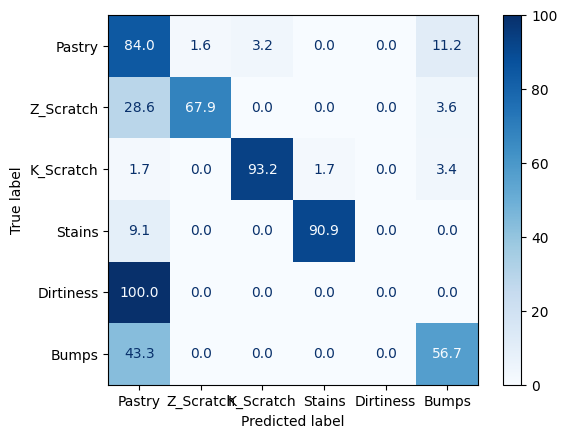

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example data (each pixel has an integer class label)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=len(val_dataset),
    shuffle=False,  # Use sampler instead of shuffle
    num_workers=NUM_OF_WORKERS
)

features, ground_truth = next(iter(val_dataloader))

images = features.to(device_name)
model.eval()
predictions = model(images)
print(predictions.shape)
predictions =  torch.argmax(predictions, dim=1).float()
y_true = ground_truth.numpy()
y_pred = predictions.detach().cpu().int().numpy()

y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

cm = confusion_matrix(y_true_flat, y_pred_flat, labels=[0, 1, 2,3,4,5])
print(cm)
# Convert to percentage (%)
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent,
                          display_labels=["Pastry", "Z_Scratch","K_Scratch"	,"Stains"	,"Dirtiness"	,"Bumps"])

disp.plot(cmap='Blues', values_format='.1f')



   




torch.Size([291, 6])
[[105   2   3   1   0  14]
 [  5  23   0   0   0   0]
 [  1   0  56   1   0   1]
 [  1   0   0  10   0   0]
 [  8   0   0   0   0   0]
 [ 27   0   0   0   0  33]]


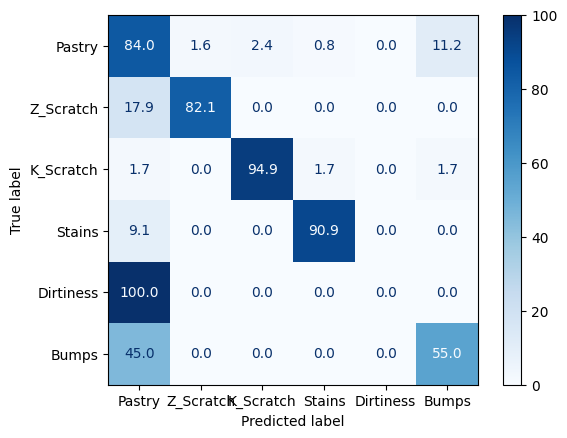

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example data (each pixel has an integer class label)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=len(val_dataset),
    shuffle=False,  # Use sampler instead of shuffle
    num_workers=NUM_OF_WORKERS
)

features, ground_truth = next(iter(val_dataloader))

images = features.to(device_name)
model.eval()
predictions = model(images)
print(predictions.shape)
predictions =  torch.argmax(predictions, dim=1).float()
y_true = ground_truth.numpy()
y_pred = predictions.detach().cpu().int().numpy()

y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

cm = confusion_matrix(y_true_flat, y_pred_flat, labels=[0, 1, 2,3,4,5])
print(cm)
# Convert to percentage (%)
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent,
                          display_labels=["Pastry", "Z_Scratch","K_Scratch"	,"Stains"	,"Dirtiness"	,"Bumps"])

disp.plot(cmap='Blues', values_format='.1f')



   




torch.Size([292, 6])
[[96  3  5  3  0 18]
 [ 6 23  0  0  0  0]
 [ 3  0 55  0  0  1]
 [ 0  0  0 10  0  1]
 [ 8  0  0  0  0  0]
 [26  1  1  0  0 32]]


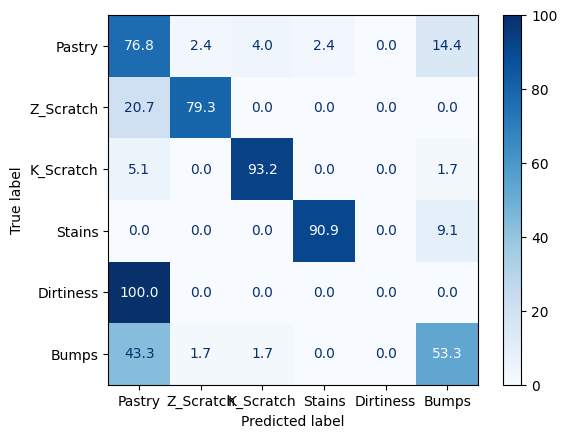

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example data (each pixel has an integer class label)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=len(test_dataset),
    shuffle=False,  # Use sampler instead of shuffle
    num_workers=NUM_OF_WORKERS
)

features, ground_truth = next(iter(test_dataloader))

images = features.to(device_name)
model.eval()
predictions = model(images)
print(predictions.shape)
predictions =  torch.argmax(predictions, dim=1).float()
y_true = ground_truth.numpy()
y_pred = predictions.detach().cpu().int().numpy()

y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

cm = confusion_matrix(y_true_flat, y_pred_flat, labels=[0, 1, 2,3,4,5])
print(cm)
# Convert to percentage (%)
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent,
                          display_labels=["Pastry", "Z_Scratch",	"K_Scratch"	,"Stains"	,"Dirtiness"	,"Bumps"])

disp.plot(cmap='Blues', values_format='.1f')



   




[[96  3  5  3  0 18]
 [ 6 23  0  0  0  0]
 [ 3  0 55  0  0  1]
 [ 0  0  0 10  0  1]
 [ 8  0  0  0  0  0]
 [26  1  1  0  0 32]]


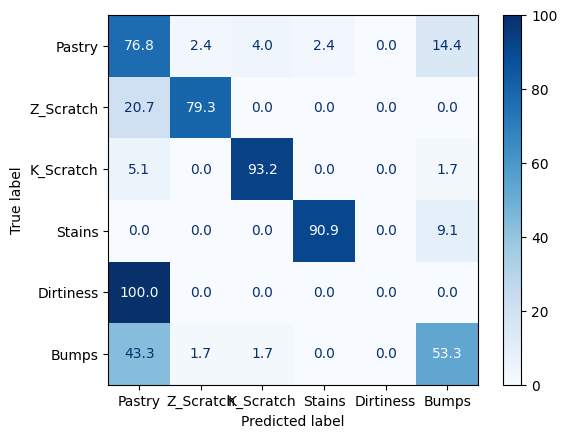

In [ ]:
cm = confusion_matrix(y_true_flat, y_pred_flat, labels=[0, 1, 2,3,4,5])
print(cm)
# Convert to percentage (%)
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent,
                          display_labels=["Pastry", "Z_Scratch",	"K_Scratch"	,"Stains"	,"Dirtiness"	,"Bumps"])

disp.plot(cmap='Blues', values_format='.1f')